In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [5]:
DATA_STORE = 'assets.h5'

In [6]:
START = 2000
END = 2018

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    print(store)
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))

<class 'pandas.io.pytables.HDFStore'>
File path: assets.h5



In [8]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


# Create monthly return series
To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [9]:
monthly_prices = prices.resample('M').last()

In [10]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 5.3 MB


To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(n_periods), that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the .stack() method, use .pipe() to apply the .clip() method to the resulting DataFrame, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using .swaplevel() to change the order of the MultiIndex levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [11]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]

for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                            .pct_change(lag)
                            .stack()
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                    upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1)
                            )

data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 521806 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   521806 non-null  float64
 1   return_2m   521806 non-null  float64
 2   return_3m   521806 non-null  float64
 3   return_6m   521806 non-null  float64
 4   return_9m   521806 non-null  float64
 5   return_12m  521806 non-null  float64
dtypes: float64(6)
memory usage: 26.0+ MB


# Drop stocks with less than 10 yrs of returns

In [12]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs > min_obs].index

data = data.loc[idx[keep, :], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB


# Momentum factors
We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [13]:
for lag in [2, 3, 6, 9, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

# Lagged returns

In [14]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   momentum_2     465935 non-null  float64
 7   momentum_3     465935 non-null  float64
 8   momentum_6     465935 non-null  float64
 9   momentum_9     465935 non-null  float64
 10  momentum_12    465935 non-null  float64
 11  momentum_3_12  465935 non-null  float64
 12  return_1m_t-1  463550 non-null  float64
 13  return_1m_t-2  461165 non-null  float64
 14  return_1m_t-3  458780 non-null  float64
 15  return_1m_t-4  456395 non

# Target: Holding Period Returns
Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [15]:
for t in [1, 2, 3, 6, 12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [16]:
cols = ['target_1m',
        'target_2m',
        'target_3m',
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.340055      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.340055  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   momentum_2     465935 non-null  float64
 7   momentum_3     465935 non-null  float64
 8   momentum_6     465935 non-null  float64
 9   momentum_9     465935 non-null  float64
 10  momentum_12    465935 non-null  float64
 11  momentum_3_12  465935 non-null  float64
 12  return_1m_t-1  463550 non-null  float64
 13  return_1m_t-2  461165 non-null  float64
 14  return_1m_t-3  458780 non-null  float64
 15  return_1m_t-4  456395 non

# Creating Financial Alpha

In [18]:
with pd.HDFStore(DATA_STORE) as store:
    data = (store['quandl/wiki/prices']
            .loc[idx['2007':'2010', 'AAPL'],
                 ['adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume']]
            .unstack('ticker')
            .swaplevel(axis=1)
            .loc[:, 'AAPL']
            .rename(columns=lambda x: x.replace('adj_', '')))

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2007-01-03 to 2010-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1008 non-null   float64
 1   high    1008 non-null   float64
 2   low     1008 non-null   float64
 3   close   1008 non-null   float64
 4   volume  1008 non-null   float64
dtypes: float64(5)
memory usage: 47.2 KB


# Compute Bollinger Bands

In [21]:
from talib import RSI, BBANDS, MACD

In [22]:
up, mid, low = BBANDS(data.close, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

# Compute Relative Strength Index

In [23]:
rsi = RSI(data.close, timeperiod=14)

# Plot results

In [25]:
data = pd.DataFrame({'AAPL': data.close, 'BB Up': up, 'BB Mid': mid, 'BB down': low, 'RSI': rsi})

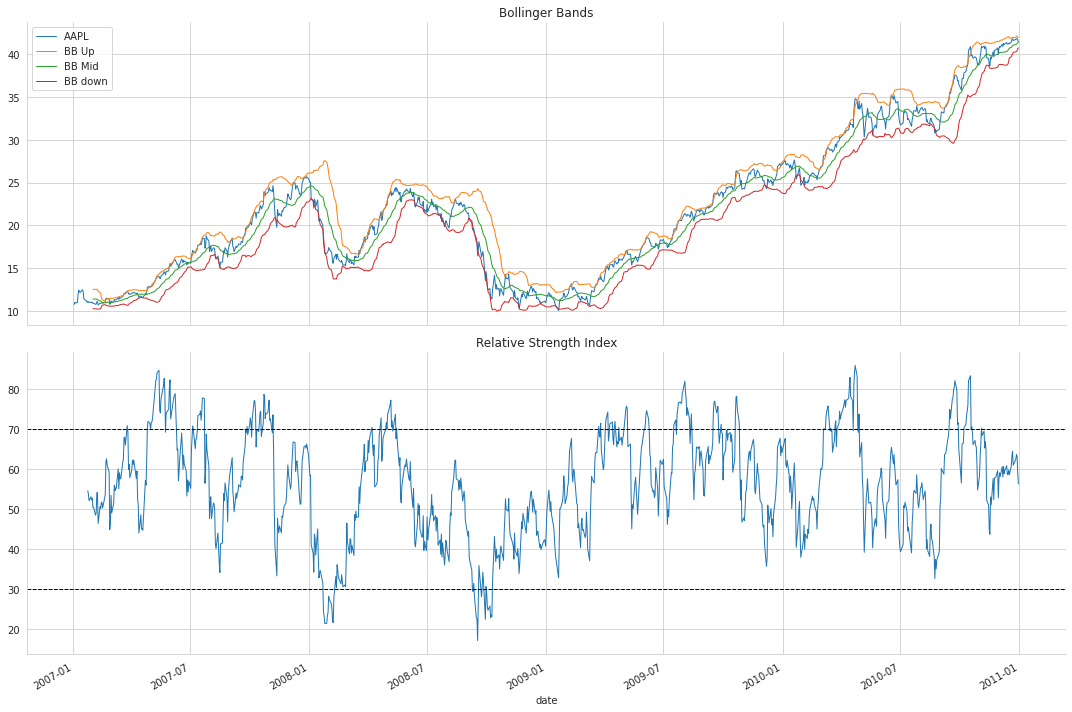

In [27]:
fig, axes= plt.subplots(nrows=2, figsize=(15, 10), sharex=True)
data.drop(['RSI'], axis=1).plot(ax=axes[0], lw=1, title='Bollinger Bands')
data['RSI'].plot(ax=axes[1], lw=1, title='Relative Strength Index')
axes[1].axhline(70, lw=1, ls='--', c='k')
axes[1].axhline(30, lw=1, ls='--', c='k')
fig.tight_layout()
sns.despine();